# Modelos: KNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import util as ut

import random

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

In [8]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

<torch._C.Generator object at 0x7fa7b9f799d0>

In [9]:
WEIGHTS_PATH = '../weights'

In [10]:
TRAIN = False

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-23 15:13:02,084 - INFO - Train: 83.74 % - Test: 7.71 %


## Entrenamiento del modelo

In [13]:
if TRAIN:
    user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [14]:
if TRAIN:
    user_predictor.plot()

In [15]:
if TRAIN:
    item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [16]:
if TRAIN:
    item_predictor.plot()

Se guardan los modelo entrenado:

In [17]:
if TRAIN:
    user_predictor.save(WEIGHTS_PATH,'knn-user-predictor ')
    item_predictor.save(WEIGHTS_PATH,'knn-item-predictor')

In [18]:
if TRAIN:
    user_predictor.delete()
    item_predictor.delete()

## Validación del modelo

In [19]:
ut.free_gpu_memory()

In [20]:
user_predictor = ml.KNNUserBasedPredictor.from_file(WEIGHTS_PATH, 'knn-user-predictor')

In [21]:
item_predictor = ml.KNNItemBasedPredictor.from_file(WEIGHTS_PATH,'knn-item-predictor')

Decoramos los predictores un con cache para disminuir los tiempo de predicción, ya que no tiene sentido realizar dos veces la misma predicción para estos modelos donde el resultado no es aleatorio:

In [22]:
cached_user_predictor = ml.CachedPredictor(user_predictor)
cached_item_predictor = ml.CachedPredictor(item_predictor)

Armamos un ensample para validar si mejora la performance de ambos modelos:

In [23]:
ensemple_predictor = ml.EnsemplePredictor([cached_user_predictor, cached_item_predictor])

In [31]:
def validation(
    predictors, 
    n_samples    = 100, 
    batch_size   = 1000, 
    n_neighbors  = 100,
    k            = [5, 10],
    user_index   = 0,
    discretizers = [dr.between(4, 5), dr.between(3, 5)],
    summary_path = '../metrics/knn'
):
    metrics    = [mt.RMSE()]

    for k, discretizer in zip(k, discretizers):
        metrics.extend([
            mt.MeanAveragePrecisionAtk(user_index=user_index, k=k, discretizer=discretizer)
        ])

    validator = ml.Validator(
        n_samples,
        batch_size,
        metrics,
        predictors
    )

    summary = validator.validate(eval_set, n_neighbors=n_neighbors)

    summary.save(summary_path)
    summary = ml.ValidatorSummary.load(summary_path)
    summary.plot(bins=12, show_table=True)


Processing:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

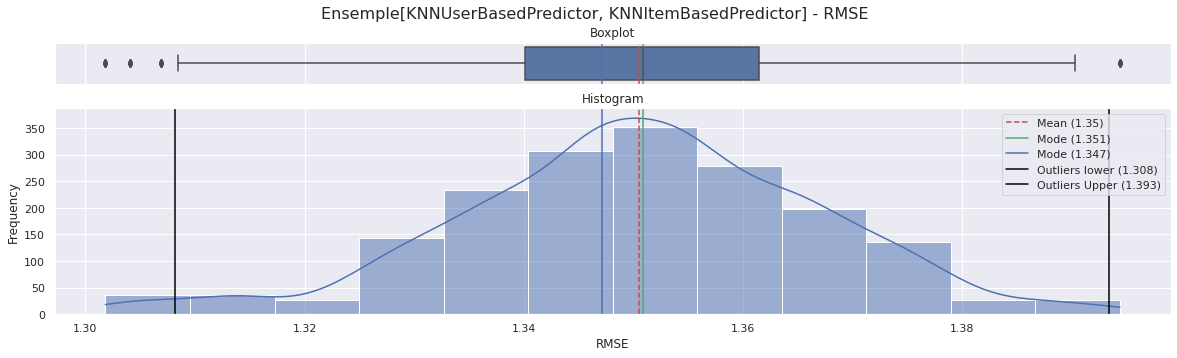


Metrics:



,RMSE
count,1800.000000
mean,1.350498
std,0.016540
min,1.301821
25%,1.340140
50%,1.350883
75%,1.361441
max,1.394402


<Figure size 1440x360 with 2 Axes>

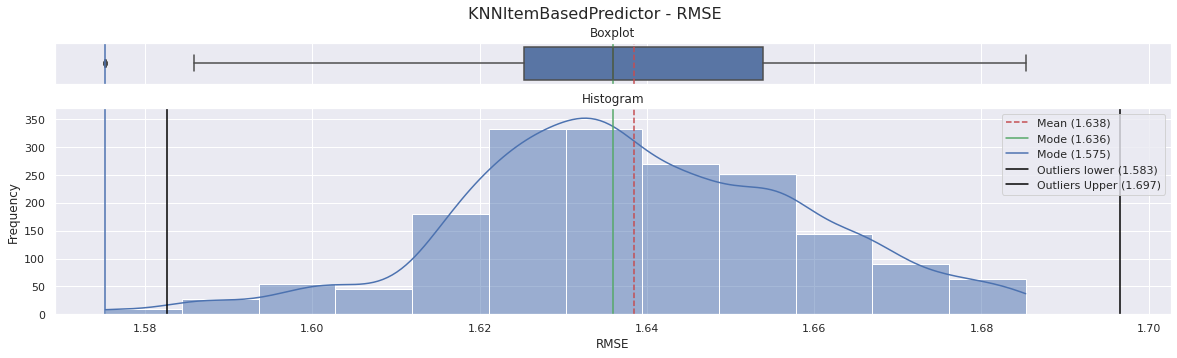


Metrics:



,RMSE
count,1800.000000
mean,1.638449
std,0.020450
min,1.575253
25%,1.625344
50%,1.635949
75%,1.653829
max,1.685283


<Figure size 1440x360 with 2 Axes>

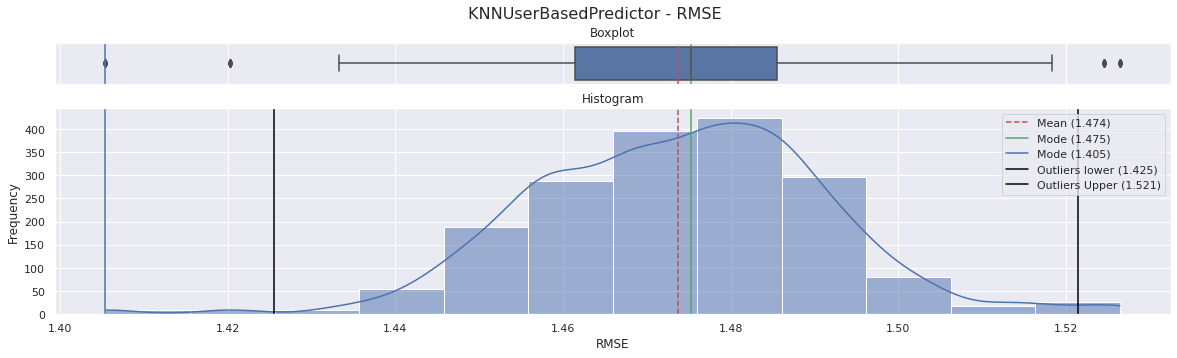


Metrics:



,RMSE
count,1800.000000
mean,1.473772
std,0.017721
min,1.405416
25%,1.461487
50%,1.475234
75%,1.485485
max,1.526458


<Figure size 1440x360 with 2 Axes>

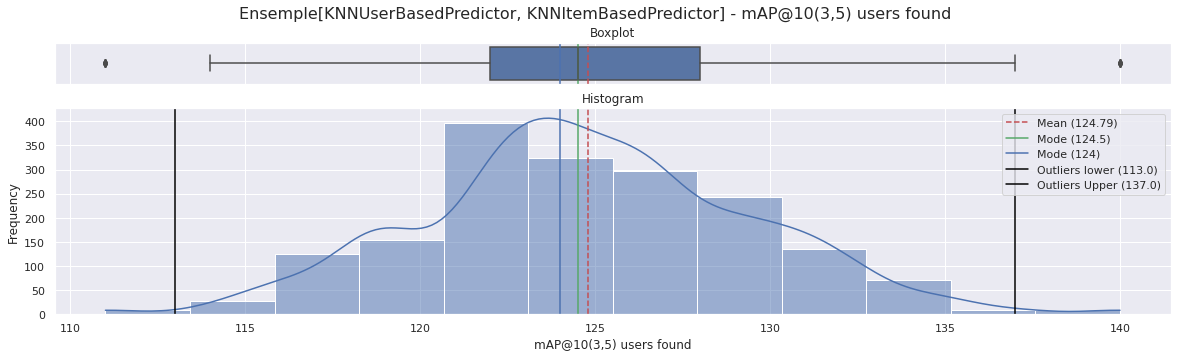


Metrics:



,"mAP@10(3,5) users found"
count,1800.000000
mean,124.790000
std,4.715745
min,111.000000
25%,122.000000
50%,124.500000
75%,128.000000
max,140.000000


<Figure size 1440x360 with 2 Axes>

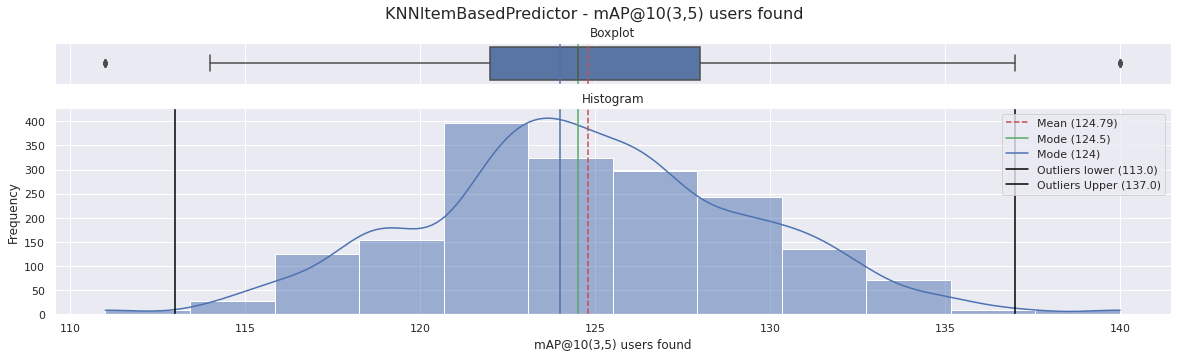


Metrics:



,"mAP@10(3,5) users found"
count,1800.000000
mean,124.790000
std,4.715745
min,111.000000
25%,122.000000
50%,124.500000
75%,128.000000
max,140.000000


<Figure size 1440x360 with 2 Axes>

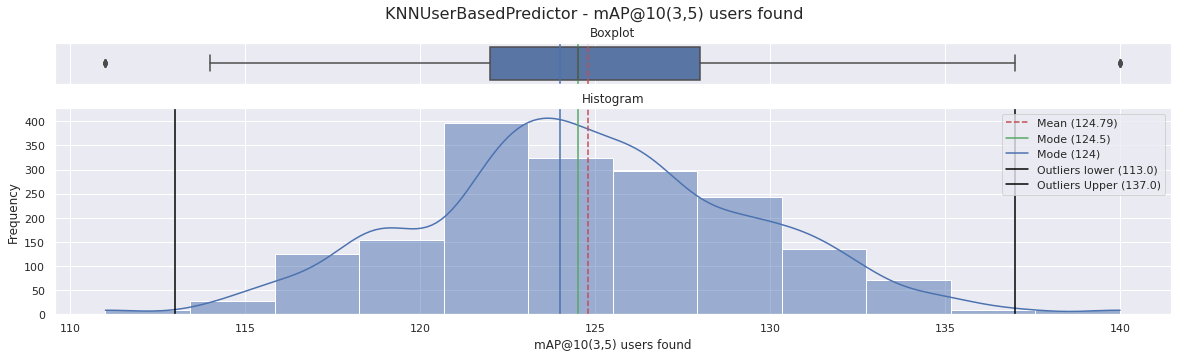


Metrics:



,"mAP@10(3,5) users found"
count,1800.000000
mean,124.790000
std,4.715745
min,111.000000
25%,122.000000
50%,124.500000
75%,128.000000
max,140.000000


<Figure size 1440x360 with 2 Axes>

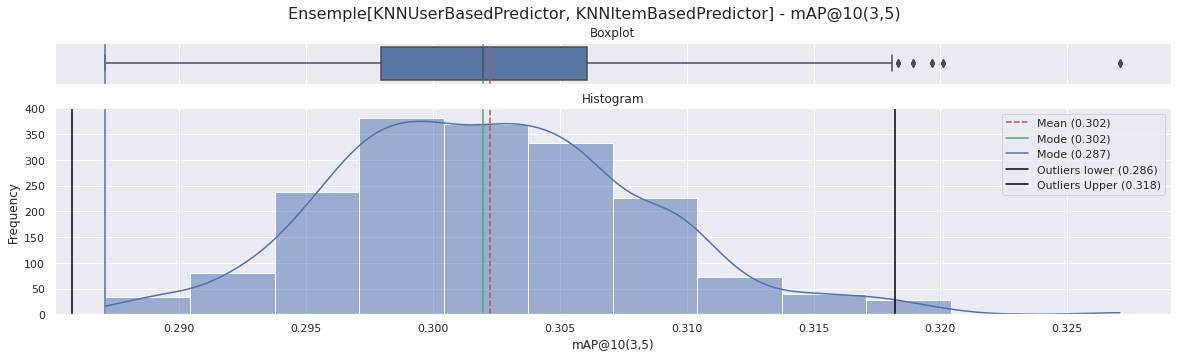


Metrics:



,"mAP@10(3,5)"
count,1800.000000
mean,0.302253
std,0.006016
min,0.287082
25%,0.297937
50%,0.301960
75%,0.306049
max,0.327080


<Figure size 1440x360 with 2 Axes>

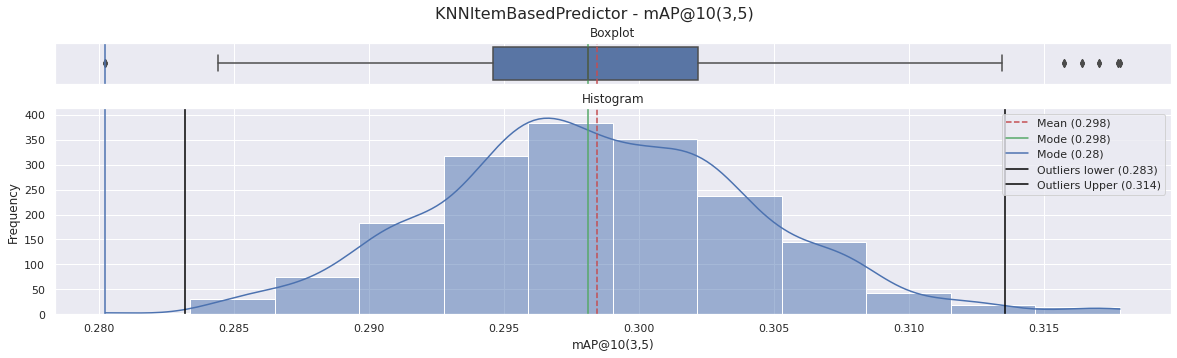


Metrics:



,"mAP@10(3,5)"
count,1800.000000
mean,0.298428
std,0.005885
min,0.280248
25%,0.294584
50%,0.298102
75%,0.302178
max,0.317808


<Figure size 1440x360 with 2 Axes>

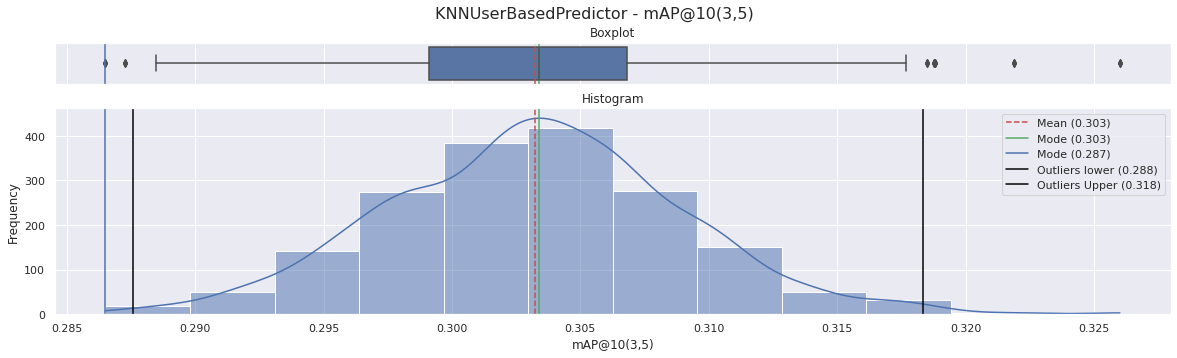


Metrics:



,"mAP@10(3,5)"
count,1800.000000
mean,0.303226
std,0.005785
min,0.286501
25%,0.299106
50%,0.303398
75%,0.306799
max,0.326016


<Figure size 1440x360 with 2 Axes>

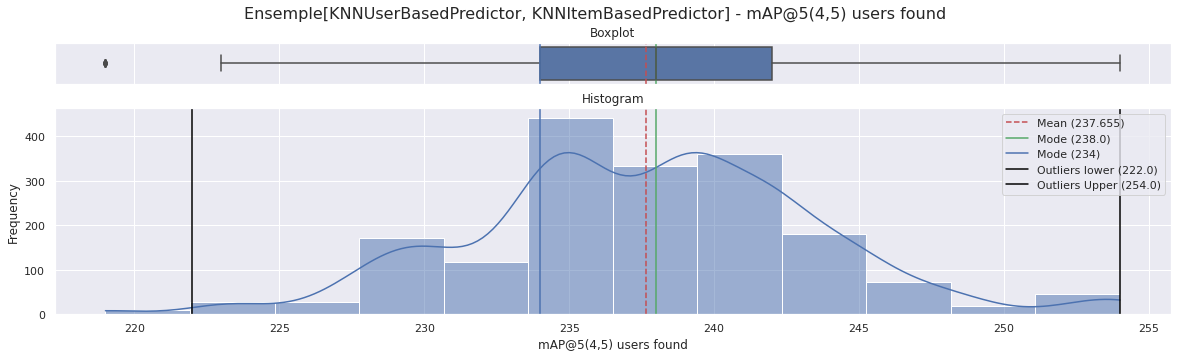


Metrics:



,"mAP@5(4,5) users found"
count,1800.00000
mean,237.65500
std,5.96454
min,219.00000
25%,234.00000
50%,238.00000
75%,242.00000
max,254.00000


<Figure size 1440x360 with 2 Axes>

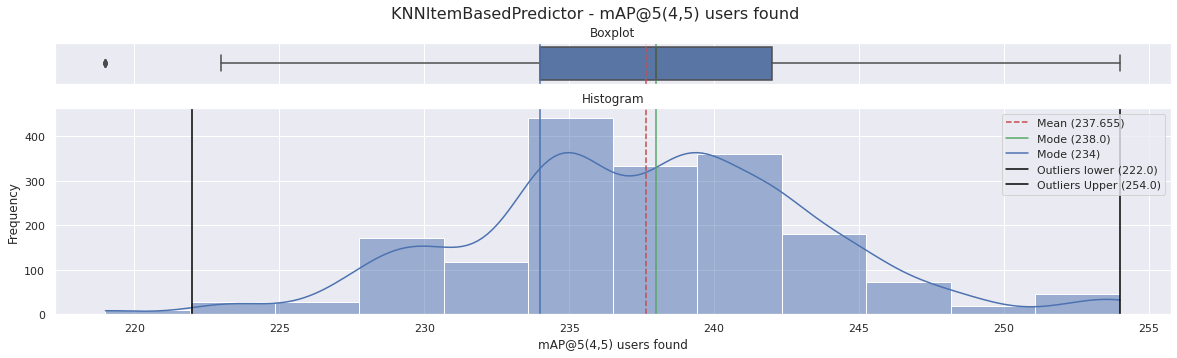


Metrics:



,"mAP@5(4,5) users found"
count,1800.00000
mean,237.65500
std,5.96454
min,219.00000
25%,234.00000
50%,238.00000
75%,242.00000
max,254.00000


<Figure size 1440x360 with 2 Axes>

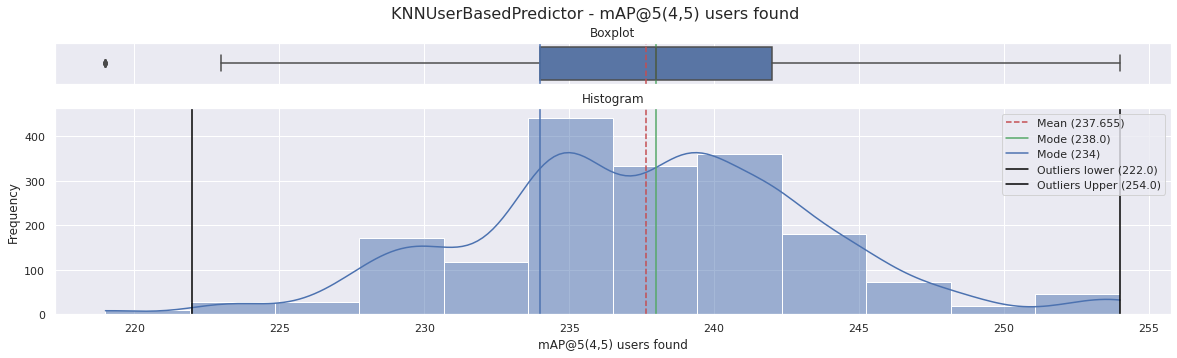


Metrics:



,"mAP@5(4,5) users found"
count,1800.00000
mean,237.65500
std,5.96454
min,219.00000
25%,234.00000
50%,238.00000
75%,242.00000
max,254.00000


<Figure size 1440x360 with 2 Axes>

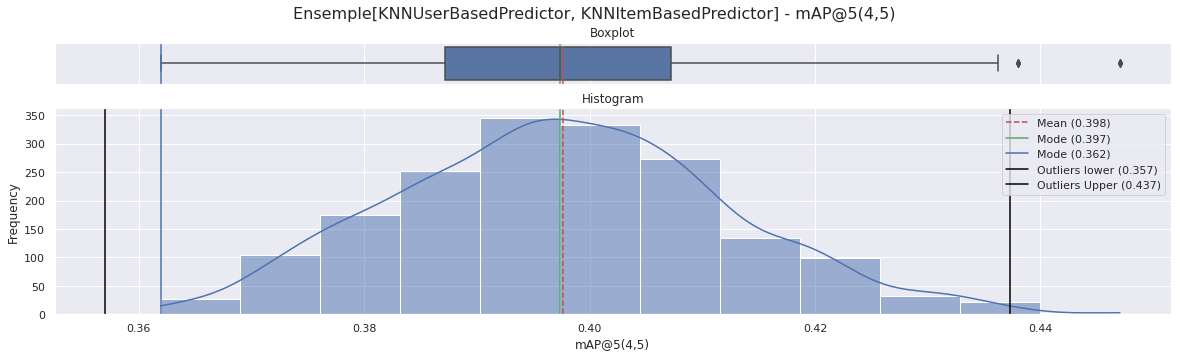


Metrics:



,"mAP@5(4,5)"
count,1800.000000
mean,0.397635
std,0.014683
min,0.361929
25%,0.387132
50%,0.397391
75%,0.407193
max,0.447065


<Figure size 1440x360 with 2 Axes>

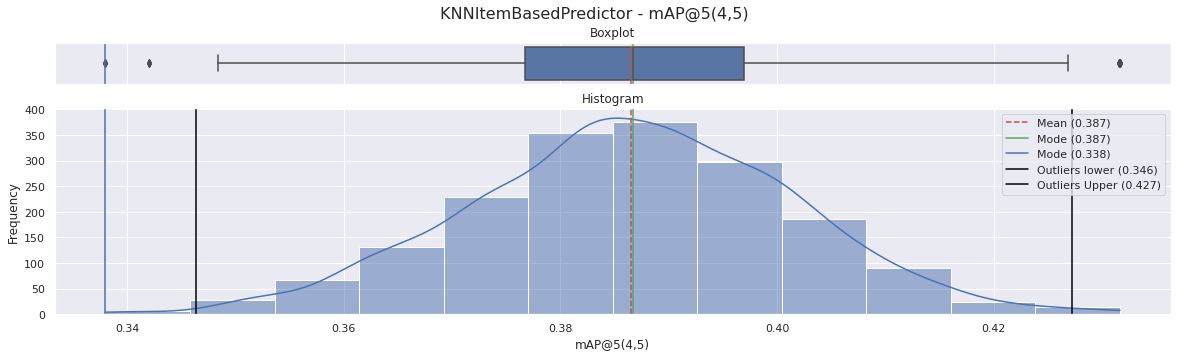


Metrics:



,"mAP@5(4,5)"
count,1800.000000
mean,0.386511
std,0.014965
min,0.338011
25%,0.376721
50%,0.386665
75%,0.396931
max,0.431632


<Figure size 1440x360 with 2 Axes>

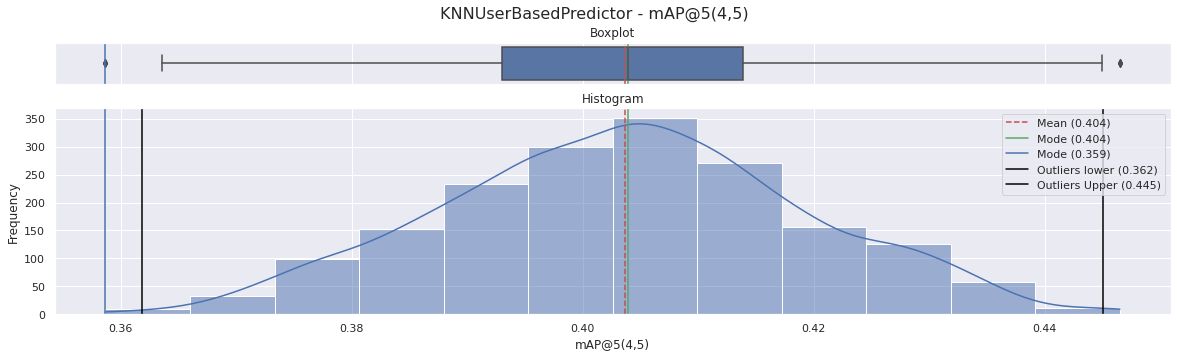


Metrics:



,"mAP@5(4,5)"
count,1800.000000
mean,0.403628
std,0.015635
min,0.358686
25%,0.393059
50%,0.403919
75%,0.413861
max,0.446513


In [32]:
validation(
    [cached_user_predictor, cached_item_predictor, ensemple_predictor],
    n_samples    = 200,
    batch_size   = 5000,
    n_neighbors  = 5000,
    summary_path = '../metrics/knn'
)